In [2]:
import numpy as np
import matplotlib.pyplot as plt

import finesse
from finesse.gaussian import HGMode
from finesse.gaussian import BeamParam
from finesse.knm import Map
from finesse.knm.matrix import KnmMatrix
from finesse.plotting import plot_field
from finesse.knm.maps import map_scattering_coefficients, scattering_coefficients_to_KnmMatrix
from finesse.plotting.graph import graphviz_draw, graphviz_draw_beam_trace
from finesse.gaussian import optimise_HG00_q_scipy, optimise_HG00_q

finesse.configure(plotting=True)


CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
kat = finesse.Model()
kat.modes(maxtem=6)

kat.parse(
    f"""
    l L0 P=1

    s s0 L0.p1 PR3.p1
    bs PR3 R=0.9999777 T=5.3e-06 alpha=0.615 Rc=36
    s s3 PR3.p2 ITM.p1 L=60

    m ITM T=0.014 L=37.5u phi=0 Rc=-1937
    s Larm ITM.p2 ETM.p1 L=3995
    m ETM T=5u L=37.5u phi=0 Rc=2247

    ad HG00 ITM.p2.o f=0 n=0 m=0
    
    ad HG20 ITM.p2.o f=0 n=2 m=0
    ad HG02 ITM.p2.o f=0 n=0 m=2

    ad HG40 ITM.p2.o f=0 n=4 m=0
    ad HG04 ITM.p2.o f=0 n=0 m=4
    ad HG22 ITM.p2.o f=0 n=2 m=2

    cavity CAVArm source=ITM.p2.o via=ETM.p1.i priority=1

    """
)

In [3]:
trace = kat.beam_trace()
qx_, qy_ = trace[kat.PR3.p1.i]
print(qx_.w)

0.054357291584643114


In [4]:
def phaseMap(w, R, xylim=4, npts=800):
    x = y = np.linspace(-1, 1, npts)*w*xylim
    xx, yy = np.meshgrid(x, y)
    
    sphere = R - R*(1 - (xx**2+yy**2)/R**2)**0.5
    parabaloid = (xx**2+yy**2)/(2*R)
    
    deltaz_map = (sphere - parabaloid)

    return deltaz_map

### Optimized HG basis for minimal coupling to 2nd order modes

# # # # # 

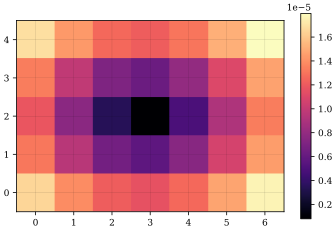

In [240]:
w = 0.0543573
R = 36
tunningHG20 = 49.23
kat3 = kat.deepcopy()

opd = phaseMap(w, R=R)
x = y = np.linspace(-1, 1, 800)*w*4
mapp = Map(x, y, opd=opd)
kat3.PR3.surface_map = mapp
# kat3.ETM.surface_map = mapp

rangee = 1e-2
deltaw01, deltaw02 = 1.19, 1.21
deltaz1, deltaz2 = 1.17, 1.18
deltaw0s = np.linspace(deltaw01, deltaw02, 5)*rangee
deltazs = np.linspace(deltaz1, deltaz2, 7)*rangee

HG20_LS = []
for deltaw0 in deltaw0s:
    temp = []
    for deltaz in deltazs:
        katt = kat3.deepcopy()
        katt.create_mismatch(katt.ITM.p1.i, w0_mm=deltaw0, z_mm=deltaz)
        katt.ETM.phi = tunningHG20
        outt = katt.run()
        HG20 = outt["HG20"]
        temp.append(abs(HG20))
    
        del katt
        del outt

    HG20_LS.append(temp)
    print("#", end=" ")

HG20_LS = np.array(HG20_LS)

plt.imshow(HG20_LS)
plt.colorbar();
# delibrate (slight) 'mode mismatch' to the arm cavity to minimize the 2nd order mode coupling

In [6]:
w_PR3 = 0.0543573
R = 36
w = w_PR3
kat0 = kat.deepcopy()

opd = phaseMap(w, R)
x = y = np.linspace(-1, 1, 800)*w*4

mapp = Map(x, y, opd=-opd)

kat0.PR3.surface_map = mapp

trace = kat0.beam_trace()
qx_old, qy_old = trace[kat0.ITM.p1.i]
print(qx_old.q, qy_old.q)

kat0.ETM.phi = 0
# kat0.ITM.p1.i.q = trace[kat0.ITM.p1.i]
# kat0.remove(kat0.CAVArm)
kat0.parse("""
    ad HG00_0 ITM.p1.i f=0 n=0 m=0
    
    ad HG20_0 ITM.p1.i f=0 n=2 m=0
    ad HG02_0 ITM.p1.i f=0 n=0 m=2

    ad HG40_0 ITM.p1.i f=0 n=4 m=0
    ad HG04_0 ITM.p1.i f=0 n=0 m=4
    ad HG22_0 ITM.p1.i f=0 n=2 m=2
""")

out0 = kat0.run()

# fields = [out0["HG00_0"], out0["HG20_0"], out0["HG02_0"], out0["HG40_0"], out0["HG04_0"], out0["HG22_0"]]
fields = [out0["HG00_0"], out0["HG20_0"], out0["HG02_0"]]
# fields = [out0["HG00"], out0["HG20"], out0["HG02"]]
fields

(-1834.8029427220185+433.02593621072276j) (-1834.8029427220185+433.02593621072276j)


[(0.9999888022418654+0j),
 (2.6351692897627905e-06-0.00019531877605442573j),
 (2.6351692896574484e-06-0.00019531877605442102j)]

In [7]:
# BeamParam.mismatch([qx_old, qy_old], kat0.CAVArm.q)

In [8]:
# mode_index = [(0,0), (2,0), (0,2), (4,0), (0,4), (2,2),]
mode_index = [(0,0), (2,0), (0,2)]
qx_new, qy_new, field_new = optimise_HG00_q(e=fields, q=(qx_old, qy_old), homs=mode_index, 
                      return_field=True, accuracy=1e-12)
qx_new.q, qy_new.q, field_new

((-1834.563715334432+433.02909768616394j),
 (-1834.5637153344321+433.02909768616377j),
 array([9.99988802e-01-2.76223449e-04j, 4.09813145e-15+1.96844389e-16j,
        4.13197193e-15+1.59348105e-17j]))

In [9]:
BeamParam.mismatch(qx_new, qx_old), BeamParam.mismatch(qy_new, qy_old)

(7.63144225896432e-08, 7.631442258949677e-08)

In [10]:
RoCITMx, RoCETMx = qx_new.roc(z=qx_new.z), qx_new.roc(z=qx_new.z + 3995)
RoCITMx, RoCETMx # 1937, 2247

(-1936.7755915835544, 2247.230882948257)

In [11]:
RoCITMy, RoCETMy = qy_new.roc(z=qy_new.z), qy_new.roc(z=qy_new.z + 3995)
RoCITMy, RoCETMy # 1937, 2247

(-1936.7755915835546, 2247.2308829482567)

### Aberration outside the arm from PR3

In [12]:
w = 0.0543573
Rc = 36
kat11 = kat.deepcopy()
kat11.ITM.p1.i.q = (qx_old, qy_old)
kat11.ITM.Rc = [RoCITMx, RoCITMy]
kat11.ETM.Rc = [RoCETMx, RoCETMy]
out11 = kat11.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")

kat12 = kat.deepcopy()

opd = phaseMap(w, R=R)
x = y = np.linspace(-1, 1, 800)*w*4
mapp = Map(x, y, opd=opd)
kat12.PR3.surface_map = mapp
out12 = kat12.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")


kat13 = kat.deepcopy()

opd = phaseMap(w, R=R)
x = y = np.linspace(-1, 1, 800)*w*4
mapp = Map(x, y, opd=opd)
kat13.PR3.surface_map = mapp

kat13.ITM.p1.i.q = (qx_old, qy_old)
kat13.ITM.Rc = [RoCITMx, RoCITMy]
kat13.ETM.Rc = [RoCETMx, RoCETMy]

out13 = kat13.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")

In [13]:
w = 0.0543573
Rc = 36
kat1 = kat.deepcopy()

opd = phaseMap(w, R=R)
x = y = np.linspace(-1, 1, 800)*w*4
mapp = Map(x, y, opd=opd)
kat1.PR3.surface_map = mapp

kat1.create_mismatch(kat1.ITM.p1.i,  w0_mm=1e-2*(deltaw01+deltaw02)/2, z_mm=1e-2*(deltaz1+deltaz2)/2)

out1 = kat1.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")

In [14]:
BeamParam.mismatch([qx_old, qy_old], kat1.CAVArm.q)

array([6.375794151225121e-31, 6.8927504337568915e-31], dtype=object)

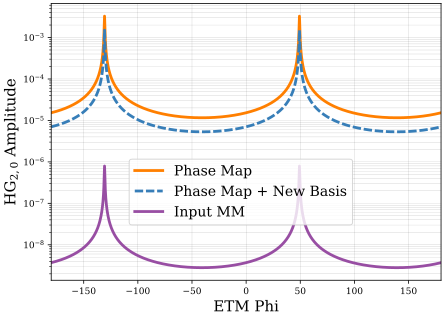

In [242]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.semilogy(out12.x1, np.abs(out12["HG20"]), color=CB_color_cycle[1], label="Phase Map", lw=2.8)
# ax.semilogy(out11.x1, np.abs(out11["HG20"]), color=CB_color_cycle[5], ls=(0, (3,3)), label="New Basis", lw=2.8)
ax.semilogy(out13.x1, np.abs(out13["HG20"]), color=CB_color_cycle[0], ls=(0, (3,1)), label="Phase Map + New Basis", lw=2.8)

ax.semilogy(out1.x1, np.abs(out1["HG20"]), ls="-", color=CB_color_cycle[5], label="Input MM", lw=2.8);

ax.set_xlabel('ETM Phi', fontsize=15)
ax.set_ylabel(r'$\mathrm{HG}_{2,0}$ Amplitude', fontsize=15)
legend = ax.legend(fontsize=14, ncols=1, loc=(0.2, 0.2));

# adjusting arm cavity eigenmode can only reduce the second order modes by a factor of two, 
# adjusting input mode matching can reduce the 2nd order mode well enough

In [16]:
index = np.abs(out1["HG20"]).argmax()
tunningHG20 = out1.x1[index]
tunningHG20

49.22999999999999

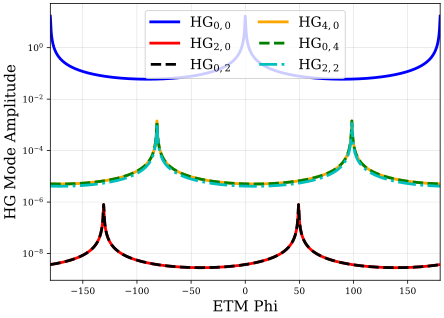

In [17]:
lw = 2.8
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.semilogy(out1.x1, np.abs(out1["HG00"]), label=r"$\mathrm{HG}_{0,0}$", lw=lw)
ax.semilogy(out1.x1, np.abs(out1["HG20"]), label=r"$\mathrm{HG}_{2,0}$", lw=lw)
ax.semilogy(out1.x1, np.abs(out1["HG02"]), label=r"$\mathrm{HG}_{0,2}$", ls="--", lw=lw)
ax.semilogy(out1.x1, np.abs(out1["HG40"]), label=r"$\mathrm{HG}_{4,0}$", lw=lw)
ax.semilogy(out1.x1, np.abs(out1["HG04"]), label=r"$\mathrm{HG}_{0,4}$", ls="--", lw=lw)
ax.semilogy(out1.x1, np.abs(out1["HG22"]), label=r"$\mathrm{HG}_{2,2}$", ls="-.", lw=lw)

ax.set_xlabel('ETM Phi', fontsize=15)
ax.set_ylabel(r'HG Mode Amplitude', fontsize=15)
legend = ax.legend(fontsize=14, ncols=2, loc="best");
# 2nd order mode coupling is minimized 

The HOM amplitude content present at HG00 mode tuning, from spherical aberration.

$$
\mathcal{L}_{m n}=a_{00 \mid n,m} \cdot T_{n,m}
$$
$a_{00 \mid n,m}$ is the single-bounce HOM amplitude scattering, $T_{n,m}$ is the HOM resonant gain, or the suppression factor due to the frequency offset: $\delta f = \left(n+m\right) \cdot \partial \Omega_{\text{HOM}}$

$$
T_{n,m} = \frac{1}{\sqrt{1 + \left(\frac{2\cdot \mathcal{F}}{\pi} \sin\left(\left(n+m\right)\pi\cdot \frac{\partial \Omega_{\text{HOM}}}{\text{FSR}}\right)\right)^2}}
$$


In [17]:
kat0 = kat.deepcopy()

Finesse = kat0.CAVArm.finesse
Fsr = kat0.CAVArm.FSR
FHOM = kat0.CAVArm.mode_separation_x
print(Finesse, Fsr, FHOM)

# print(2*FHOM/Fsr/np.pi*180)

def Tnm(order):
    return 1/(1 + 4*Finesse**2/np.pi**2*np.sin(order*np.pi*FHOM/Fsr)**2)**0.5

FHOM*7/Fsr,

443.1179205928998 37520.958448060075 5130.84394355151


(0.957222552152516,)

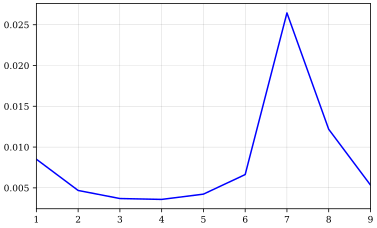

In [20]:
gains = [Tnm(order) for order in range(1, 10)]
plt.plot(range(1, 10), gains, );

In [19]:
Nc = 2000
RHG40 = np.abs(out1["HG40"])[Nc]/(np.abs(out1["HG00"])[Nc])
RHG22 = np.abs(out1["HG22"])[Nc]/(np.abs(out1["HG00"])[Nc])
RHG20 = np.abs(out1["HG20"])[Nc]/(np.abs(out1["HG00"])[Nc])
RHG40, RHG22, RHG20

(3.031341770784032e-07, 2.47508078587116e-07, 2.2166342728465056e-10)

In [20]:
w = 0.0543573
R = 36
k = 2*np.pi/(1064e-9)

HOMfactor40 = k*w**4/(32*R**3)*np.sqrt(6)
HOMfactor22 = k*w**4/(32*R**3)*2
HOMfactor20 = k*w**4/(32*R**3)*4*np.sqrt(2)
factor4th = Tnm(4)
factor2nd = Tnm(2)
HOMfactor40*factor4th, HOMfactor22*factor4th, HOMfactor20*factor2nd
# the initial HG mode scattering, multiplied by the optical gain ratio, matches the HOM content inside the arm from the Finesse simulation

(3.0313356063599277e-07, 2.4750751582373563e-07, 9.143302004760785e-07)

### Check optical gain

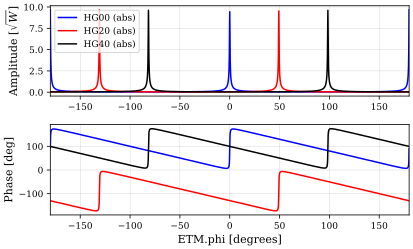

In [21]:
kat3 = kat.deepcopy()
mode_index = [(0,0), (2,0), (4,0),]

for index in mode_index: 
    n, m = index
    factor = 1
    phase = 0
    
    kat3.L0.tem(n=n, m=m, factor=factor, phase=phase)
kat3.parse("ad HG00_0 ITM.p1.i f=0 n=0 m=0")

out3 = kat3.run("xaxis(ETM.phi, 'lin', -180, 180, 4001)")
out3.plot(["HG00", "HG20", "HG40"]);

In [22]:
(np.abs(out3["HG00"]).max()/np.abs(out3["HG00_0"]).max())**2

280.5084502821333

In [23]:
out3 = kat3.run("noxaxis()")
np.abs(out3["HG40"])/np.abs(out3["HG00"]), np.abs(out3["HG20"])/np.abs(out3["HG00"])

(0.0035838195100645655, 0.004680753917586746)

In [24]:
Tnm(4), Tnm(2), 

(0.0035838195100645633, 0.004680753917586753)

### Spherical aberration HOM scattering with cavity enhacement

### Aberration inside the arm from ETM

In [227]:
ETM_Tran = 2000e-6
kat0 = kat.deepcopy()
kat0.ETM.set_RTL(T=ETM_Tran, L=37.5e-6)

Finesse = kat0.CAVArm.finesse
Fsr = kat0.CAVArm.FSR
FHOM = kat0.CAVArm.mode_separation_x
print(Finesse, Fsr, FHOM)
print(Finesse/np.pi)

def Tnm(order):
    return 1/(1 + 4*Finesse**2/np.pi**2*np.sin(order*np.pi*FHOM/Fsr)**2)**0.5

388.4124603455571 37520.958448060075 5130.84394355151
123.6355260449604


# # # # # 

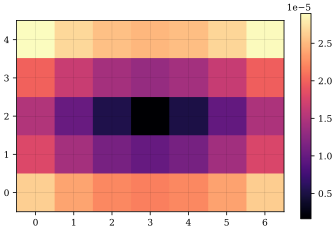

In [213]:
wETM = 0.061615
w = wETM
R = 36 #2247
xylim = 4
npts = 1000
LARM = 3995 #3000 
tunningHG20 = 49.23 #-50.805 

kat3 = kat.deepcopy()
kat3.Larm.L = LARM
kat3.ETM.set_RTL(T=ETM_Tran, L=37.5e-6)

opd = phaseMap(w, R=R, xylim=xylim, npts=npts)
x = y = np.linspace(-1, 1, npts)*w*xylim
mapp = Map(x, y, opd=opd)
kat3.ETM.surface_map = mapp

rangee = 1e-2
# xylim 4
# deltaw03, deltaw04 = 1.02, 1.06
# deltaz3, deltaz4 = -0.255, -0.24

# xylim 5
# deltaw03, deltaw04 = -2.7, -2.4
# deltaz3, deltaz4 = 0.5, 0.7

# xylim 6
# deltaw03, deltaw04 = 1.3, 1.6
# deltaz3, deltaz4 = -0.5, -0.2

# xylim 7
# deltaw03, deltaw04 = 0.7, 0.95
# deltaz3, deltaz4 = -0.3, -0.1

# xylim 8
# deltaw03, deltaw04 = 0.7, 1.3
# deltaz3, deltaz4 = -0.4, -0.1

# xylim 9
# deltaw03, deltaw04 = -2.4, -2.2
# deltaz3, deltaz4 = 0.5, 0.58

# xylim 4, Rc=36
deltaw03, deltaw04 = -2.7, -2.66
deltaz3, deltaz4 = 0.63, 0.642

deltaw0s = np.linspace(deltaw03, deltaw04, 5)*rangee
deltazs = np.linspace(deltaz3, deltaz4, 7)*rangee

HG20_LS = []
for deltaw0 in deltaw0s:
    temp = []
    for deltaz in deltazs:
        katt = kat3.deepcopy()
        katt.create_mismatch(katt.ITM.p1.i, w0_mm=deltaw0, z_mm=deltaz)
        katt.ETM.phi = tunningHG20
        outt = katt.run()
        HG20 = outt["HG20"]
        temp.append(abs(HG20))

        del katt
        del outt

    HG20_LS.append(temp)
    print("#", end=" ")

HG20_LS = np.array(HG20_LS)

plt.imshow(HG20_LS)
plt.colorbar();

In [274]:
w = wETM

R = 36 #2247
xylim = 4
npts = 1000
kat2 = kat.deepcopy()
kat2.ETM.set_RTL(T=ETM_Tran, L=37.5e-6)
kat2.Larm.L = LARM
print(2*kat2.CAVArm.finesse/np.pi)

opd = phaseMap(w, R, xylim=xylim, npts=npts)
# print(opd.mean())
x = y = np.linspace(-1, 1, npts)*w*xylim

mapp = Map(x, y, opd=opd)

kat2.ETM.surface_map = mapp

gauss_mmITM = kat2.create_mismatch(kat2.ITM.p1.i, w0_mm=1e-2*(deltaw03+deltaw04)/2, z_mm=1e-2*(deltaz3+deltaz4)/2)

out2 = kat2.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")


kat4 = kat.deepcopy()
kat4.ETM.set_RTL(T=ETM_Tran, L=37.5e-6)

kat4.Larm.L = LARM

opd = phaseMap(w, R, xylim=xylim, npts=npts)
x = y = np.linspace(-1, 1, npts)*w*xylim

mapp = Map(x, y, opd=opd)

kat4.ETM.surface_map = mapp

out4 = kat4.run("xaxis(ETM.phi, 'lin', -180, 180, 4000)")

247.2710520899208


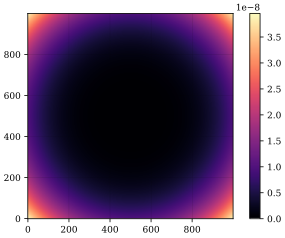

In [275]:
plt.imshow(opd)
plt.colorbar();

In [276]:
kat2.CAVArm.storage_time/(2*3995/3e8)

123.72111713860434

In [277]:
print(kat2.mismatches_table(numfmt='{:.4e}'))
np.abs(out2["HG40"]).max()/(np.abs(out2["HG00"]).max())

┌──────────────────────╥──────────────┬──────────────┐
│       Coupling       ║ Mismatch (x) │ Mismatch (y) │
╞══════════════════════╬══════════════╪══════════════╡
│ ITM.p1.i -> ITM.p2.o ║   9.0008e-08 │   9.0008e-08 │
├──────────────────────╫──────────────┼──────────────┤
│ ITM.p1.i -> ITM.p1.o ║   2.2803e-12 │   2.2803e-12 │
├──────────────────────╫──────────────┼──────────────┤
│ ITM.p2.i -> ITM.p1.o ║   9.0008e-08 │   9.0008e-08 │
└──────────────────────╨──────────────┴──────────────┘



7.039137135097827e-05

In [278]:
trace = kat2.beam_trace()
qx_, qy_ = trace[kat2.ETM.p1.i]
print(qx_.w)

0.06161509809531186


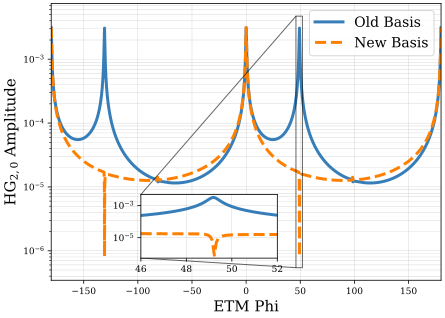

In [279]:
lw = 3
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.semilogy(out4.x1, np.abs(out4["HG20"]), label=r"Old Basis", lw=lw, color=CB_color_cycle[0])
ax.semilogy(out2.x1, np.abs(out2["HG20"]), label=r"New Basis", lw=lw, color=CB_color_cycle[1], ls="--")

axins = ax.inset_axes([0.23, 0.08, 0.35, 0.23],)
axins.semilogy(out4.x1, np.abs(out4["HG20"]), lw=lw, color=CB_color_cycle[0])
axins.semilogy(out2.x1, np.abs(out2["HG20"]), lw=lw, color=CB_color_cycle[1], ls="--")
axins.set_xlim([46, 52])
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.6)

ax.set_xlabel('ETM Phi', fontsize=15)
ax.set_ylabel(r'$\mathrm{HG}_{2,0}$ Amplitude', fontsize=15)
legend = ax.legend(fontsize=14, ncols=1, loc="best");
# reducing the 2nd order mode by delibrate input mode mismatch don't change the 2nd order mode at the HG00 mode tunning

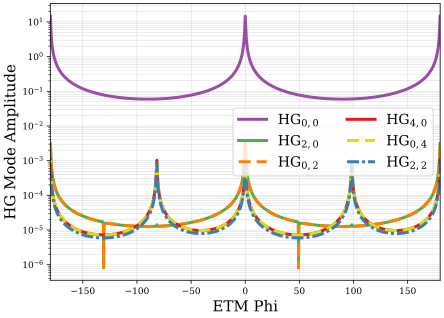

In [280]:
lw = 3
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.semilogy(out2.x1, np.abs(out2["HG00"]), label=r"$\mathrm{HG}_{0,0}$", lw=lw, color=CB_color_cycle[5])
ax.semilogy(out2.x1, np.abs(out2["HG20"]), label=r"$\mathrm{HG}_{2,0}$", lw=lw, color=CB_color_cycle[2])
ax.semilogy(out2.x1, np.abs(out2["HG02"]), label=r"$\mathrm{HG}_{0,2}$", ls=(0, (4,2)), lw=lw, color=CB_color_cycle[1])
ax.semilogy(out2.x1, np.abs(out2["HG40"]), label=r"$\mathrm{HG}_{4,0}$", lw=lw, color=CB_color_cycle[7])
ax.semilogy(out2.x1, np.abs(out2["HG04"]), label=r"$\mathrm{HG}_{0,4}$", ls=(0, (4,2)), lw=lw, color=CB_color_cycle[8])
ax.semilogy(out2.x1, np.abs(out2["HG22"]), label=r"$\mathrm{HG}_{2,2}$", ls=(0, (4,1,1,1)), lw=lw, color=CB_color_cycle[0])

ax.set_xlabel('ETM Phi', fontsize=15)
ax.set_ylabel(r'HG Mode Amplitude', fontsize=15)
legend = ax.legend(fontsize=14, ncols=2, loc="best");

In [270]:
Nc = 2000
RHG40 = np.abs(out2["HG40"])[Nc]/(np.abs(out2["HG00"])[Nc])
RHG22 = np.abs(out2["HG22"])[Nc]/(np.abs(out2["HG00"])[Nc])
RHG20 = np.abs(out2["HG20"])[Nc]/(np.abs(out2["HG00"])[Nc])
RHG40, RHG22, RHG20

(7.03911473861308e-05, 5.747411962458302e-05, 0.00021215852077906267)

In [271]:
w = wETM
R = 36 #2247
HOMfactor40 = k*w**4/(32*R**3)*np.sqrt(6)
HOMfactor22 = k*w**4/(32*R**3)*2
HOMfactor20 = k*w**4/(32*R**3)*4*np.sqrt(2)
factor4th = Tnm(4)
factor2nd = Tnm(2)
HOMfactor40*factor4th, HOMfactor22*factor4th, HOMfactor20*factor2nd

(5.709178808949932e-07, 4.6615249774126466e-07, 1.7220354814623922e-06)

In [272]:
RHG40/(HOMfactor40*factor4th), RHG22/(HOMfactor22*factor4th), RHG20/(HOMfactor20*factor2nd)

(123.29469743666618, 123.2946726727263, 123.20217734357759)

In [273]:
print(Finesse/np.pi)

123.6355260449604


In [282]:
# 4th order mode to the 00 mode amplitude ratio inside the ARM at the 00 mode tuning can be explained by:

# the single-reflection HOM coupling coefficients (kw^4/R^3) * HOM resonant gain factors (Tnm) * Number of rough trips (Finesse/pi)

### Maps need higher spatial frequency for much smaller beam sizes compared to roc

In [36]:
w = 0.061615
R = 2247
xylim = 4
maxtem = 6
npts = 1000

q = BeamParam(w=w, rc=R)

opd = phaseMap(w, R, xylim=xylim, npts=npts)
print(opd.mean())
x = y = np.linspace(-1, 1, npts)*w*xylim

Z = np.exp(
    -1j * k * opd * 2
)


factor =  k*w**4/(32*R**3)
print(factor)
qx1, qy1, qx2, qy2 = q, q, q, q
K = map_scattering_coefficients((qx1, qy1, qx2, qy2), maxtem, x, y, Z)

for mode in ["00", "02", "20", "04", "40", "22"]:
    n = int(mode[0])
    m = int(mode[1])
    print(f"HG00 -> {mode}:", abs(K[0, n, 0, m])/factor)
    # print(f"HG00 -> {mode}:", abs(K[0, n, 0, m])/abs(K[0, 0, 0, 0]))
    # print()

HOMfactor40 = abs(K[0, 4, 0, 0])/abs(K[0, 0, 0, 0])
HOMfactor22 = abs(K[0, 2, 0, 2])/abs(K[0, 0, 0, 0])
HOMfactor20 = abs(K[0, 2, 0, 0])/abs(K[0, 0, 0, 0])
# when the beam size is too small compared to the roc, the HOM coupling coefficients from spherical aberration is NOT k*w**4/(32*R**3)?

6.345887084328114e-14
2.344362987023537e-10
HG00 -> 00: 4265551049.6180954
HG00 -> 02: 30.70178154429905
HG00 -> 20: 30.701781719660026
HG00 -> 04: 69.97636772940668
HG00 -> 40: 69.97636709504606
HG00 -> 22: 35.9252843483785
